Loaded image points with shape: (2, 600, 10)
Computed centroids with shape: (2, 10)
Centered points with shape: (2, 600, 10)
Constructed measurement matrix W with shape: (20, 600)
Performed SVD. Shapes -> U: (20, 3), D: (3, 3), Vt: (3, 600)
Computed camera matrices Mi with shape: (10, 2, 3)
Computed 3D points X with shape: (600, 3)
Optimization succeeded.
Optimized transformation matrix C:
[[ 0.10988231 -0.00510801  0.00021515]
 [ 0.00219124  0.11011263  0.00396681]
 [ 0.00181976  0.002383    0.11232606]]
Adjusted camera matrices using C.
Adjusted 3D points using C^{-1}.
Adjusted camera matrices Mi with shape: (10, 2, 3)
Adjusted 3D points X with shape: (600, 3)


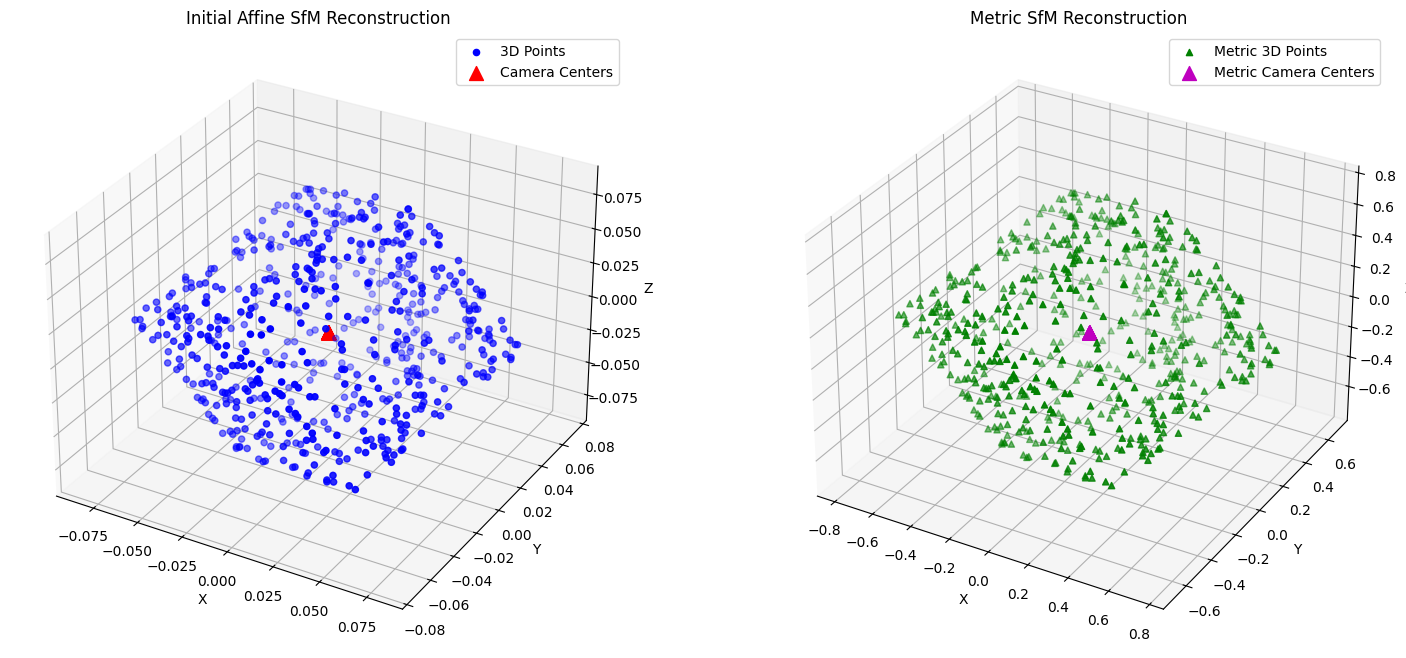

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

def load_image_points(mat_file_path):
    """
    Load the image points from a .mat file.

    Parameters:
    - mat_file_path: str, path to the .mat file.

    Returns:
    - image_points: numpy array of shape (2, 600, 10)
    """
    mat = scipy.io.loadmat(mat_file_path)
    # Assuming the variable name inside the .mat file is 'image_points'
    # Adjust the key if it's different
    if 'image_points' in mat:
        image_points = mat['image_points']
    else:
        # If the variable name is different, find the first array with the correct shape
        for key in mat:
            if isinstance(mat[key], np.ndarray) and mat[key].shape == (2, 600, 10):
                image_points = mat[key]
                break
        else:
            raise KeyError("Could not find 'image_points' in the .mat file.")
    return image_points

def compute_centroids(image_points):
    """
    Compute the centroid of points in each view.

    Parameters:
    - image_points: numpy array of shape (2, n_points, n_views)

    Returns:
    - centroids: numpy array of shape (2, n_views)
    """
    centroids = np.mean(image_points, axis=1)  # Mean over points
    return centroids

def center_points(image_points, centroids):
    """
    Center the points by subtracting the centroid in each view.

    Parameters:
    - image_points: numpy array of shape (2, n_points, n_views)
    - centroids: numpy array of shape (2, n_views)

    Returns:
    - centered_points: numpy array of shape (2, n_points, n_views)
    """
    centered_points = image_points - centroids[:, np.newaxis, :]
    return centered_points

def construct_measurement_matrix(centered_points):
    """
    Construct the measurement matrix W from centered data.

    Parameters:
    - centered_points: numpy array of shape (2, n_points, n_views)

    Returns:
    - W: numpy array of shape (2 * n_views, n_points)
    """
    n_views = centered_points.shape[2]
    n_points = centered_points.shape[1]
    W = np.zeros((2 * n_views, n_points))

    for i in range(n_views):
        W[2*i, :] = centered_points[0, :, i]    # x-coordinates
        W[2*i + 1, :] = centered_points[1, :, i]  # y-coordinates
    return W

def perform_svd(W, rank=3):
    """
    Perform Singular Value Decomposition on W.

    Parameters:
    - W: numpy array of shape (2 * n_views, n_points)
    - rank: int, number of singular values to keep

    Returns:
    - U: numpy array of shape (2 * n_views, rank)
    - D: numpy array of shape (rank, rank)
    - Vt: numpy array of shape (rank, n_points)
    """
    U, S, Vt_full = np.linalg.svd(W, full_matrices=False)
    U = U[:, :rank]
    S = S[:rank]
    Vt = Vt_full[:rank, :]
    D = np.diag(S)
    return U, D, Vt

def compute_camera_matrices(U, D):
    """
    Compute the camera matrices Mi from U and D.

    Parameters:
    - U: numpy array of shape (2 * n_views, rank)
    - D: numpy array of shape (rank, rank)

    Returns:
    - M: numpy array of shape (n_views, 2, 3)
    """
    n_views = U.shape[0] // 2
    M = np.zeros((n_views, 2, 3))

    for i in range(n_views):
        # Each camera matrix Mi is 2x3
        # Extract the corresponding rows from U
        Ui = U[2*i:2*i+2, :]  # Shape (2, rank)
        Mi = Ui @ D  # Shape (2, rank)
        M[i, :, :] = Mi
    return M

def compute_3D_points(Vt):
    """
    Compute the 3D world points from Vt.

    Parameters:
    - Vt: numpy array of shape (rank, n_points)

    Returns:
    - X: numpy array of shape (n_points, 3)
    """
    # Each row of Vt corresponds to a 3D point
    X = Vt[:3, :].T  # Shape (n_points, 3)
    return X

def optimize_C(M):
    """
    Optimize the transformation matrix C to enforce orthonormality constraints
    on the camera matrices M_i C.

    Constraints:
    - Each row of M_i C has unit norm.
    - The two rows of M_i C are orthogonal.

    Parameters:
    - M: numpy array of shape (n_views, 2, 3)

    Returns:
    - C_opt: numpy array of shape (3, 3), the optimized transformation matrix
    """
    n_views = M.shape[0]

    def cost_func(C_flat):
        C = C_flat.reshape(3, 3)
        cost = 0.0
        for i in range(n_views):
            Mi = M[i, :, :]  # Shape (2, 3)
            MiC = Mi @ C      # Shape (2, 3)
            row1 = MiC[0, :]  # Shape (3,)
            row2 = MiC[1, :]  # Shape (3,)
            # Orthonormality constraints
            norm1 = np.dot(row1, row1) - 1  # Should be 0
            norm2 = np.dot(row2, row2) - 1  # Should be 0
            orth = np.dot(row1, row2)       # Should be 0
            # Accumulate squared errors
            cost += norm1**2 + norm2**2 + orth**2
        return cost

    # Initial guess for C: Identity matrix
    C0 = np.eye(3).flatten()

    # Perform optimization using BFGS algorithm
    result = minimize(cost_func, C0, method='BFGS')

    if result.success:
        C_opt = result.x.reshape(3, 3)
        print("Optimization succeeded.")
        print("Optimized transformation matrix C:")
        print(C_opt)
        return C_opt
    else:
        raise ValueError(f"Optimization failed: {result.message}")

def adjust_M_and_X(M, X, C):
    """
    Adjust the camera matrices M and 3D points X using the transformation matrix C.

    Parameters:
    - M: numpy array of shape (n_views, 2, 3)
    - X: numpy array of shape (n_points, 3)
    - C: numpy array of shape (3, 3)

    Returns:
    - M_new: numpy array of shape (n_views, 2, 3)
    - X_new: numpy array of shape (n_points, 3)
    """
    # Adjust camera matrices: M' = M C
    M_new = np.zeros_like(M)
    for i in range(M.shape[0]):
        M_new[i, :, :] = M[i, :, :] @ C
    print("Adjusted camera matrices using C.")

    # Adjust 3D points: X' = C^{-1} X
    try:
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        raise ValueError("Transformation matrix C is singular and cannot be inverted.")
    X_new = (C_inv @ X.T).T  # Shape: (n_points, 3)
    print("Adjusted 3D points using C^{-1}.")

    return M_new, X_new

def plot_reconstructed_structure(X, M, ti, X_metric=None, M_metric=None):
    """
    Plot the reconstructed 3D points and camera positions.

    Parameters:
    - X: numpy array of shape (n_points, 3)
    - M: numpy array of shape (n_views, 2, 3)
    - ti: numpy array of shape (2, n_views)
    - X_metric: numpy array of shape (n_points, 3), optional
    - M_metric: numpy array of shape (n_views, 2, 3), optional
    """
    fig = plt.figure(figsize=(18, 8))

    # Initial Affine Reconstruction
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', marker='o', label='3D Points')

    # Approximate Camera Centers for Initial Reconstruction
    # Since it's affine, we approximate camera centers as the translation vectors ti extended with zero z-coordinate
    camera_centers = np.hstack((ti.T, np.zeros((ti.shape[1], 1))))
    ax1.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2],
               c='r', marker='^', s=100, label='Camera Centers')

    ax1.set_title('Initial Affine SfM Reconstruction')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()
    ax1.grid(True)

    # Metric Reconstruction
    if X_metric is not None and M_metric is not None:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(X_metric[:, 0], X_metric[:, 1], X_metric[:, 2], c='g', marker='^', label='Metric 3D Points')

        # Approximate Camera Centers for Metric Reconstruction
        camera_centers_metric = np.hstack((ti.T, np.zeros((ti.shape[1], 1))))
        ax2.scatter(camera_centers_metric[:, 0], camera_centers_metric[:, 1], camera_centers_metric[:, 2],
                   c='m', marker='^', s=100, label='Metric Camera Centers')

        ax2.set_title('Metric SfM Reconstruction')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.legend()
        ax2.grid(True)

    plt.show()

def main():
    # Path to the .mat file
    mat_file_path = 'sfm_points.mat'

    # Step 1: Load the image points
    image_points = load_image_points(mat_file_path)  # Shape: (2, 600, 10)
    print(f"Loaded image points with shape: {image_points.shape}")

    # Step 2: Compute the centroids (translations ti)
    centroids = compute_centroids(image_points)  # Shape: (2, 10)
    print(f"Computed centroids with shape: {centroids.shape}")

    # Step 3: Center the points
    centered_points = center_points(image_points, centroids)  # Shape: (2, 600, 10)
    print(f"Centered points with shape: {centered_points.shape}")

    # Step 4: Construct the measurement matrix W
    W = construct_measurement_matrix(centered_points)  # Shape: (20, 600)
    print(f"Constructed measurement matrix W with shape: {W.shape}")

    # Step 5: Perform SVD
    U, D, Vt = perform_svd(W, rank=3)
    print(f"Performed SVD. Shapes -> U: {U.shape}, D: {D.shape}, Vt: {Vt.shape}")

    # Step 6: Compute camera matrices Mi
    M = compute_camera_matrices(U, D)  # Shape: (10, 2, 3)
    print(f"Computed camera matrices Mi with shape: {M.shape}")

    # Step 7: Compute 3D points Xj
    X = compute_3D_points(Vt)  # Shape: (600, 3)
    print(f"Computed 3D points X with shape: {X.shape}")

    # Step 8: Optimize transformation matrix C
    try:
        C_opt = optimize_C(M)
    except ValueError as e:
        print(e)
        return

    # Step 9: Adjust M and X using C_opt
    M_metric, X_metric = adjust_M_and_X(M, X, C_opt)
    print(f"Adjusted camera matrices Mi with shape: {M_metric.shape}")
    print(f"Adjusted 3D points X with shape: {X_metric.shape}")

    # Step 10: Visualization
    plot_reconstructed_structure(X, M, centroids, X_metric, M_metric)

if __name__ == "__main__":
    main()